In [1]:
import random
import sys
import matplotlib.pyplot as plt
from IPython.display import clear_output
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.basilisk_amm import ConstantProductPoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import steady_swaps, constant_product_arbitrage, invest_all
from model.amm.global_state import GlobalState, fluctuate_prices, oscillate_prices

# same seed, same parameters = same simulation result
random.seed(42)

price_dict = {
    'R1': 3,
    'R2': 0.7,
    'USD': 1
}

initial_state = GlobalState(
    pools={
        # 'USD/R1': ConstantProductPoolState(
        #     tokens={
        #         'USD': 10000000,
        #         'R1': 10000000 / price_dict['R1']
        #     },
        #     trade_fee=0.01
        # ),
        'R1/R2': ConstantProductPoolState(
            tokens={
                'R1': 10000000 / price_dict['R1'],
                'R2': 10000000 / price_dict['R2']
            },
            trade_fee=0.01
        )
    },
    agents = {
        'LP': Agent(
            holdings={'R1': 1000000, 'R2': 1000000},
            trade_strategy=invest_all(pool_id='R1/R2')
        ),
        'Trader1': Agent(
            holdings={'R1': 10000000, 'R2': 42000000}
        ),
        'Trader2': Agent(
            holdings={'R1': 10000000, 'R2': 42000000}
        ),
        'Arbitrageur': Agent(
            holdings={'R1': 100000, 'R2': 1000000, 'USD': 0},
            trade_strategy=constant_product_arbitrage('R1/R2')
        )
    },
    external_market=price_dict,
    evolve_function=fluctuate_prices(volatility={'R1': 0.01, 'R2': 0.01})
    # oscillate_prices(
    #     tokens={
    #         'R1': {'period': 2, 'magnitude': 2}, 
    #         'R1': {'period': 2, 'magnitude': 2}
    #     }
    # )
)

events = []
raw_events = []
for i in range(100):
    # have the traders trade in opposite directions so it won't force equal levels of arbitrage
    copy_state = initial_state.copy()
    copy_state.agents['Trader1'].trade_strategy=steady_swaps(
        pool_id='R1/R2',
        usd_amount=i+1,
        asset_list=['R1', 'R2']
    )
    copy_state.agents['Trader2'].trade_strategy=steady_swaps(
        pool_id='R1/R2',
        usd_amount=i+1,
        asset_list=['R2', 'R1']
    )
    clear_output(wait=True)
    print(f'Running simulation... {i}%')
    raw_events.append(
        run.run(copy_state, time_steps=5000, silent=True),
    )
    # reset prices to original
    final_state = raw_events[-1][-1]['state']
    final_state.external_market = initial_state.external_market
    # arbitrage one last time
    final_state = constant_product_arbitrage('R1/R2').execute(final_state, 'Arbitrageur')
    # post-process
    events.append(
        processing.postprocessing(
            raw_events[i], ['impermanent_loss', 'trade_volume', 'pool_val']
        )
    )
    
print('finished.')

Running simulation... 99%
finished.


In [24]:
arbitrage_fraction=[]
LP_profit = []
pool_profit = []
for run in events:
    trader_volume = sum(
        pu.get_datastream(run, agent='Trader1', prop='trade_volume') +
        pu.get_datastream(run, agent='Trader2', prop='trade_volume')
    )
    
    arb_volume = sum(
        pu.get_datastream(run, agent='Arbitrageur', prop='trade_volume')
    )
    
    arbitrage_fraction.append((arb_volume / (arb_volume + trader_volume))**0.01)
    
    LP_profit.append(
        run[-1]['state'].agents['LP'].withdraw_val
        - run[0]['state'].agents['LP'].withdraw_val
    )
    
    pool_profit.append(
        run[-1]['state'].pools['R1/R2'].pool_val / run[-1]['state'].agents['LP'].withdraw_val
    )
    

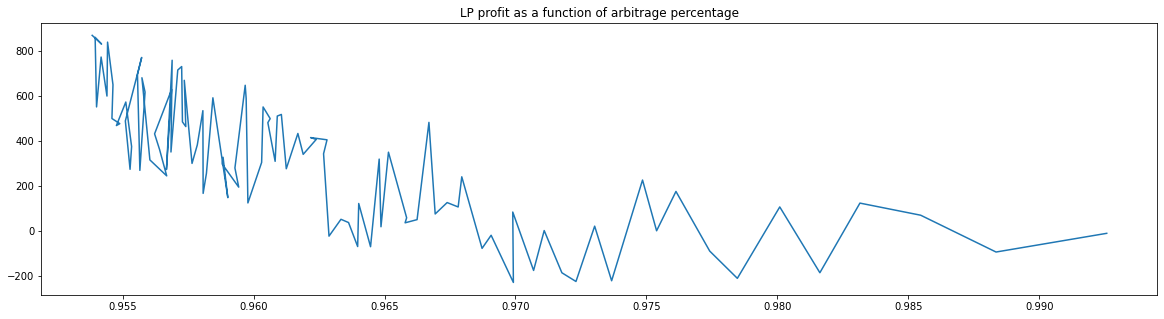

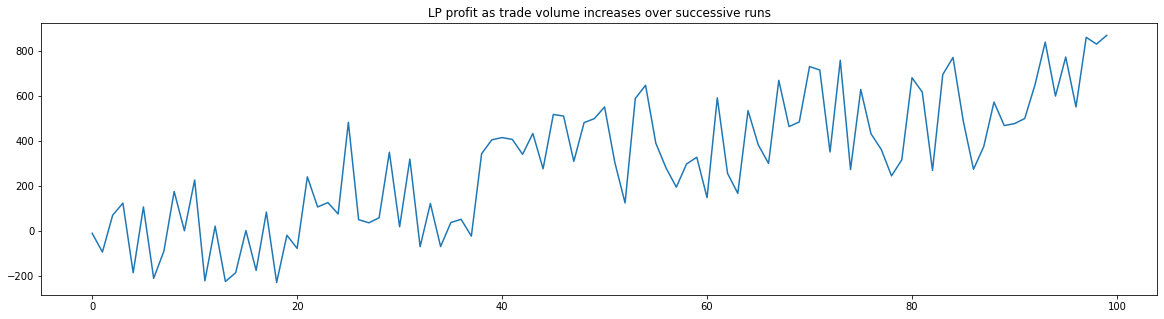

In [36]:
plt.figure(figsize=(20, 5))
ax = plt.subplot(111, title='LP profit as a function of arbitrage percentage')
ax.plot(arbitrage_fraction, LP_profit)

plt.figure(figsize=(20, 5))
ax = plt.subplot(111, title='LP profit as trade volume increases over successive runs')
ax.plot(range(len(events)), LP_profit)


100


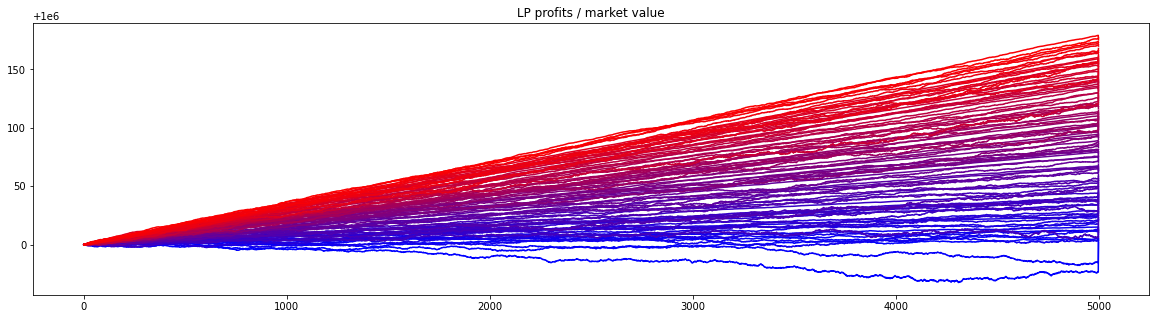

In [35]:
# define a red/blue spectrum, with blue being the beginning of the simulation (low trade volume) and red being the end (high)
color = [f'#{hex(int(i * 255 / runs))[2:].zfill(2)}00{hex(int(255 - i * 255 / runs))[2:].zfill(2)}' for i in range(runs)]
print(len(events))
plt.figure(figsize=(20, 5))
ax1 = plt.subplot(111, title='LP profits / market value')
# ax2 = plt.subplot(312)
# ax3 = plt.subplot(313)

for i, run in enumerate(events):
    LP_holdings = pu.get_datastream(run, agent='LP', prop='withdraw_val')
    R1_val = pu.get_datastream(run, asset='R1')
    R2_val = pu.get_datastream(run, asset='R2')
    ax1.plot(range(len(run)), [LP_holdings[j] / (R1_val[j] + R2_val[j]) for j in range(len(run))], color=color[i], label=i)
    # ax2.plot(range(len(run)), pu.get_datastream(run, agent='Arbitrageur2', prop='trade_volume'))
# plt.legend()